In [128]:
import kagglegym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import bz2
import base64
import pickle as pk
import warnings
import math

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Exploratory analysis

In [143]:
# The "environment" is our interface.
env = kagglegym.make()

# We get our initial observation by calling "reset".
o = env.reset()

#excl = [env.ID_COL_NAME, env.SAMPLE_COL_NAME, env.TARGET_COL_NAME, env.TIME_COL_NAME]

excl = ["id", "timestamp", "y"]
col = [c for c in o.train.columns if c not in excl]
train = o.train.loc[:, col]

# Total number of NA values per observation.
train_NA_values = train.isnull().sum(axis=1)

# Sigmoid transformation
#for c in col:
 #   train.loc[:, c] = 1 / (1 + np.exp(-train.loc[:, c]))
    
# Record NA values and then fill them with the median.
d_mean = train.median(axis=0)

for c in col:
    train.loc[:, c + "_nan"] = pd.isnull(train[c])
    d_mean[c + "_nan"] = 0
    
train = train.fillna(d_mean)

train.loc[:, "is_null"] = train_NA_values

In [ ]:
# Add by ID and timestamp: std & mean + nb assets

In [102]:
#######
# Train pickle model
#######
full_train = pd.read_hdf("train.h5")

### Evolution of target value and number of assets by timestamp

In [126]:
# Plot the correlation of the variables with the target value.

# MODIFIED
# With the new columns deltas
correlation = []
columns = []

train=train.fillna(d_mean)
# Remove outliers
train = train[abs(train["y"]) < 0.086]

for c in cols:
    columns.append(c)
    correlation.append(np.corrcoef(train[c], train["y"])[0, 1])
    
corr_df = pd.DataFrame({"abs_corr": abs(np.array(correlation))}, index = cols)
corr_df = corr_df.sort_values("abs_corr")

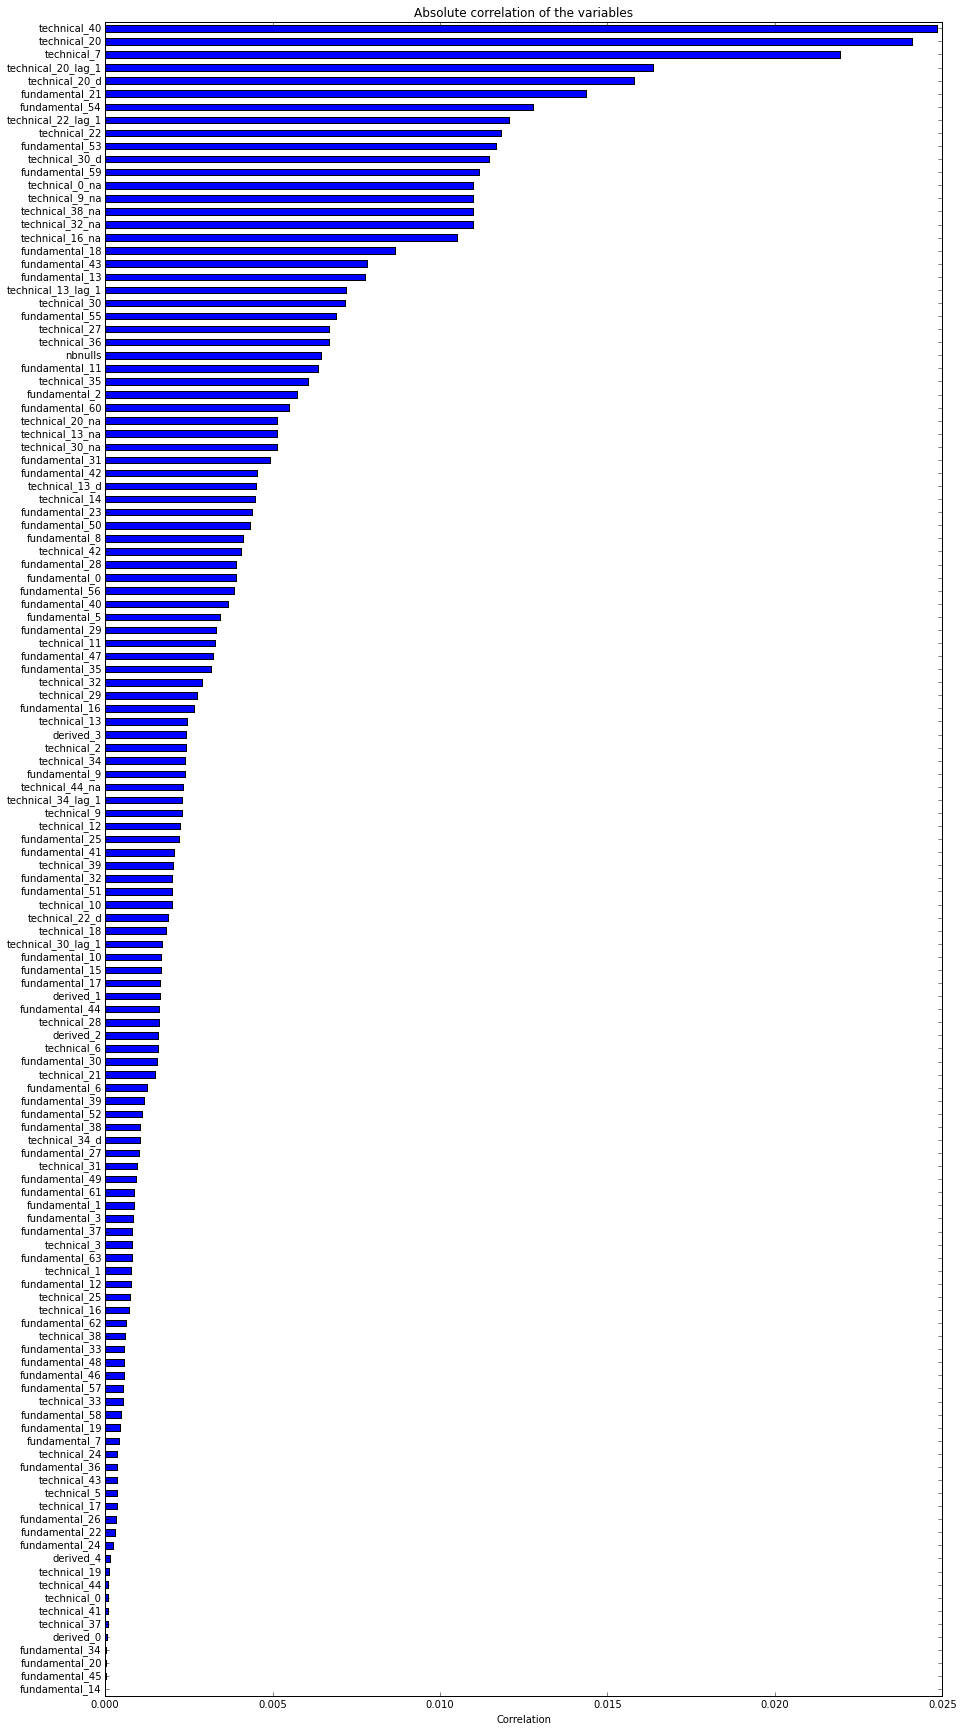

In [129]:
fig, ax = plt.subplots(figsize=(15, 30))
grid = np.arange(len(correlation))
ax.set_yticks(grid + 0.5)
ax.set_title("Absolute correlation of the variables")
ax.set_xlabel("Correlation")
ax.set_yticklabels(columns, rotation="horizontal")
corr_df.plot.barh(ax=ax, legend=False)
plt.show()

#cols2fit=['technical_22','technical_20', 'technical_30_d', 'technical_20_d', 'technical_30', 
#'technical_13', 'technical_34', "technical_20_lag_1", "technical_22_lag_1"]

The most correlated variables are: technical_20, technical_30, fundamental_11.

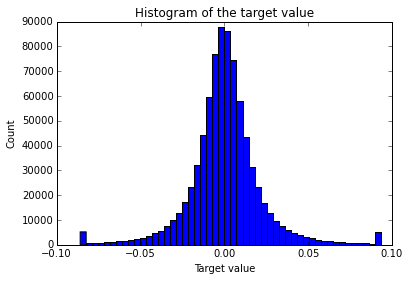

In [7]:
# Plot histogram of the target value.
plt.hist(o.train["y"], bins=50)
plt.title("Histogram of the target value")
plt.xlabel("Target value")
plt.ylabel("Count")
plt.show()

Notice the two spikes at the extremes of the histogram: the target might have been clipped and should be dealt with accordingly in our following linear model.

### Time series

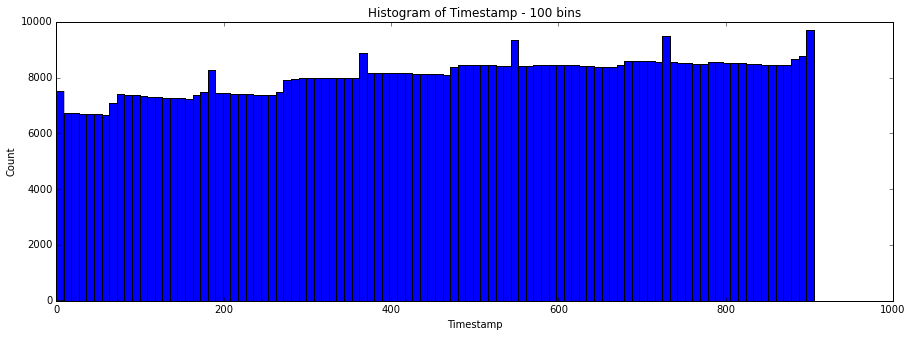

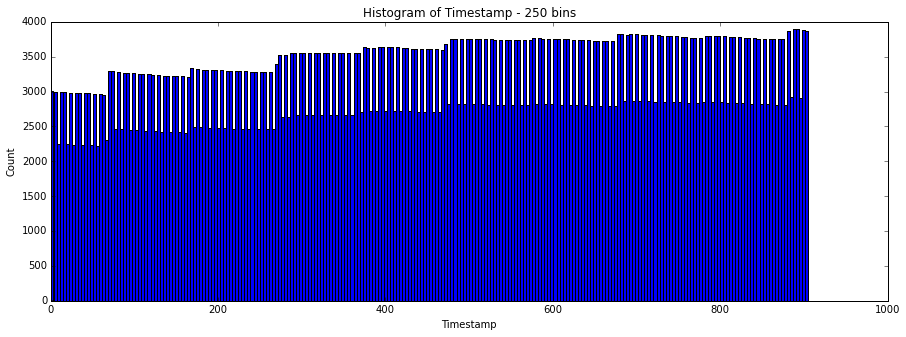

In [19]:
# Timestamp repartition
timestamp = o.train.timestamp.values
for bins in [100, 250]:
    plt.figure(figsize=(15, 5))
    plt.hist(timestamp, bins=bins)
    plt.xlabel("Timestamp")
    plt.ylabel("Count")
    plt.title("Histogram of Timestamp - {} bins".format(bins))

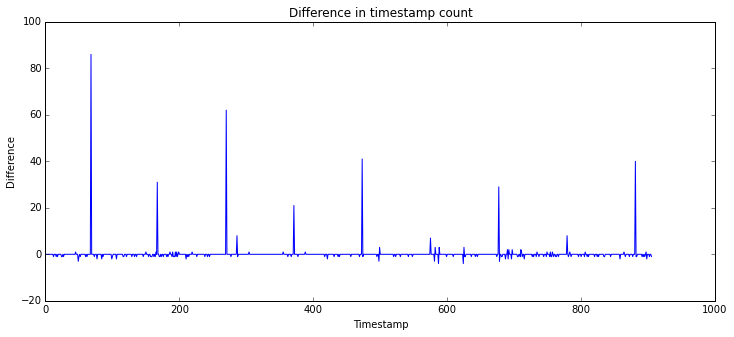

0      NaN
1     99.0
2    103.0
3    101.0
4    102.0
5    204.0
6    204.0
Name: timestamp, dtype: float64

In [3]:
time_diff = o.train.groupby(["timestamp"])["timestamp"].count().diff()

plt.figure(figsize=(12, 5))
plt.plot(time_diff)
plt.title("Difference in timestamp count")
plt.xlabel("Timestamp")
plt.ylabel("Difference")
plt.show()

pd.Series(time_diff[time_diff > 10].index).diff()

In [4]:
# Peaks can be approximated by 100*x + 70
time_diff[time_diff > 5]

timestamp
68     86.0
167    31.0
270    62.0
286     8.0
371    21.0
473    41.0
575     7.0
677    29.0
779     8.0
881    40.0
Name: timestamp, dtype: float64

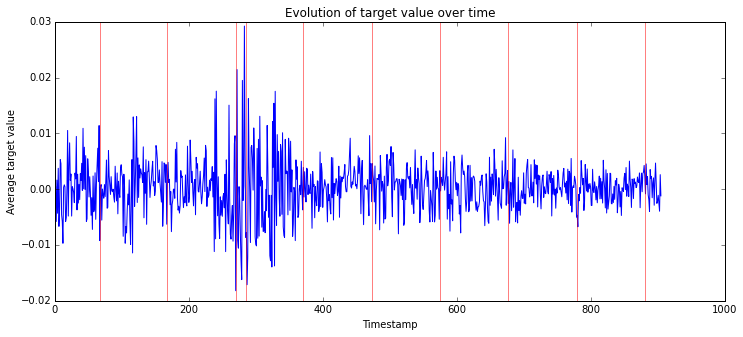

In [44]:
# Target value distribution over timestamp
y_distribution = o.train.groupby(["timestamp"])["y"].mean()
plt.figure(figsize=(12, 5))
plt.plot(y_distribution)
plt.xlabel("Timestamp")
plt.ylabel("Average target value")
plt.title("Evolution of target value over time")
for i in time_diff[time_diff > 5].index:
    plt.axvline(x=i, linewidth=0.5, color="red")
plt.show()

In [5]:
peak_dict = dict(((time_diff > 5).map(lambda x: 1 if x else 0)
                  + (time_diff > 10).map(lambda x: 1 if x else 0)))

## Models

In [103]:
low_y_cut = -0.075
high_y_cut = 0.075
y_is_above_cut = (o.train.y > high_y_cut)
y_is_below_cut = (o.train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
model_1 = LinearRegression(n_jobs=-1)
model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
            o.train.loc[y_is_within_cut, "y"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [104]:
# Fit an ExtraTreesRegressor
t0 = time()

extra_trees = ExtraTreesRegressor(n_estimators=200, max_depth=6, n_jobs=-1, 
                                  random_state=17, verbose=0)
model_2 = extra_trees.fit(train, o.train["y"])

train = []

print("Running time: {0}s.".format(time() - t0))

Running time: 1722.89324713s.


In [94]:
# Using pickle to save model.
#saved_model_2 = base64.standard_b64encode(bz2.compress(pk.dumps(model_2)))
#print(saved_model_2)

In [10]:
model_2_str = """
"""

# base model with sigmoid transformation

In [11]:
# Load saved model.
# Add "encoding="latin1" to the pk.loads method to decode in Python 3
warnings.simplefilter("ignore", UserWarning)
model_2 = pk.loads(bz2.decompress(base64.standard_b64decode(model_2_str)))
model_2

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=4,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=-1, oob_score=False, random_state=17,
          verbose=0, warm_start=False)

## Prevent overfitting

In [82]:
# A custom function to compute the R score
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

## Prediction

In [105]:
#https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659
ymean_dict = dict(o.train.groupby(["id"])["y"].median())

t0 = time()

y_real = []
y_predict = []
cum_reward = []
timestamp_list = []

while True:
    test = o.features.loc[:, col]

    # Total number of NA values per observation.
    test_NA_values = test.isnull().sum(axis=1)
    
    # Sigmoid transformation
    #for c in col:
        #test.loc[:, c] = 1 / (1 + np.exp(-test.loc[:, c]))
    
    # Fill NA values.
    for c in col:
        test.loc[:, c + "_nan"] = pd.isnull(test[c])

    test = test.fillna(d_mean)
    
    test.loc[:, "is_null"] = test_NA_values

    pred = o.target
    test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)
    
    # Ponderation of the two models.
    pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                 + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))

    # Add the median of the target value by ID.
    pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] 
                           if x["id"] in ymean_dict 
                           else x["y"], axis=1)
    
    # The target values have 6 decimals in the training set.
    pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]
    
    current_y_real = list(full_train.loc[
            full_train["timestamp"] == o.features.timestamp[0], "y"].values)
    current_y_predict = list(pred["y"].values)
    
    y_real.extend(current_y_real)
    y_predict.extend(current_y_predict)
    
    current_reward = get_reward(np.array(y_real), np.array(y_predict))
    cum_reward.append(current_reward)
    
    timestamp_list.append(o.features.timestamp[0])
    
    o, reward, done, info = env.step(pred)
    if done:
        print("Finished", info["public_score"])
        break
    if o.features.timestamp[0] % 100 == 0:
        print(current_reward)

print("Running time: {0}s.".format(time() - t0))

0.0120561385983
0.00853670258148
0.0164804278316
0.014440084008
-0.0110857910212
0.00887544708997
0.0274960238222
0.0262467319802
0.0239089511734
('Finished', 0.023592082210886534)
Running time: 523.676628828s.


## Cumulative R value

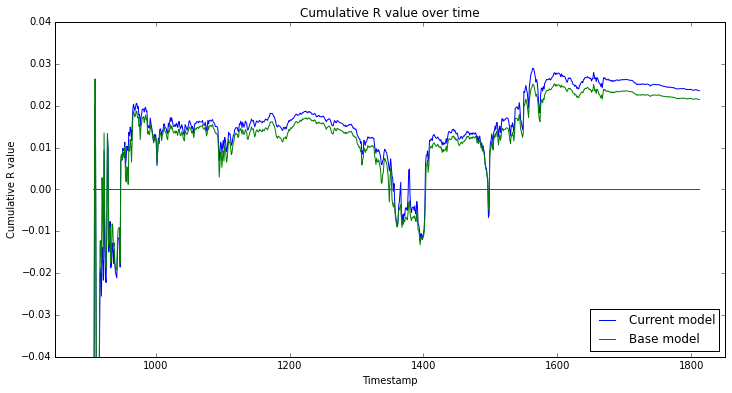

In [106]:
base_cum_R = pd.read_csv("base_cum_R.csv", encoding="utf-8")

plt.figure(figsize=(12,6))
plt.plot(base_cum_R["Timestamp"], cum_reward, color="blue", label="Current model")
plt.plot(base_cum_R["Timestamp"], base_cum_R["Cumulative_R"], color="green", label="Base model")
plt.plot(base_cum_R["Timestamp"], [0]*len(timestamp_list), color="red")
plt.title("Cumulative R value over time")
plt.xlabel("Timestamp")
plt.ylabel("Cumulative R value")
plt.xlim(850, 1850)
plt.ylim(-0.04, 0.04)
plt.legend(loc="lower right")
plt.show()

##Cross-validation

## Approximating LB score

## New model

In [ ]:
## Ideas ##
# Clip the y values -> decrease score
# Add the lagged technical_20 - technical_30 linear model
# Correct the diff method -> doesn't work, mb remove the first timestamp of each ID?
# Add shifted values + nb of NaN
# Add mean y by id with a dictionary
# Replace with Ransac linear regression
# Increase/Decrease number of models to keep
# Moving average of y
# Columns "id", "timestamp", "y", 6 decimals 

In [1]:
import kagglegym
import numpy as np
import pandas as pd
import random
from sklearn import ensemble, linear_model, metrics

In [124]:
env = kagglegym.make()
o = env.reset()
train = o.train
print(train.shape)
d_mean= train.median(axis=0)
train["nbnulls"]=train.isnull().sum(axis=1)
col=[x for x in train.columns if x not in ['id', 'timestamp', 'y']]

rnd=17

#keeping na information on some columns (best selected by the tree algorithms)
add_nas_ft=True
nas_cols=['technical_9', 'technical_0', 'technical_32', 'technical_16', 'technical_38', 
'technical_44', 'technical_20', 'technical_30', 'technical_13']
#columns kept for evolution from one month to another (best selected by the tree algorithms)
add_diff_ft=True
diff_cols=['technical_22','technical_20', 'technical_30', 'technical_13', 'technical_34']

#homemade class used to infer randomly on the way the model learns
class createLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd=random_state
        self.n=n_neighbours
        self.max_elts=max_elts
        self.verbose=verbose
        self.neighbours=[]
        self.clfs=[]
        
    def fit(self,train,y):
        if self.rnd!=None:
            random.seed(self.rnd)
        if self.max_elts==None:
            self.max_elts=len(train.columns)
        list_vars=list(train.columns)
        random.shuffle(list_vars)
        
        lastscores=np.zeros(self.n)+1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars=list_vars[self.n:]
        
        for elt in list_vars:
            indice=0
            scores=[]
            for elt2 in self.neighbours:
                if len(elt2)<self.max_elts:
                    clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.mean_squared_error(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains=lastscores-scores
            if gains.max()>0:
                temp=gains.argmax()
                lastscores[temp]=scores[temp]
                self.neighbours[temp].append(elt)

        indice=0
        for elt in self.neighbours:
            clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice=indice+1
                    
    def transform(self, train):
        indice=0
        for elt in self.neighbours:
            #this line generates a warning. Could be avoided by working and returning
            #with a copy of train.
            #kept this way for memory management
            train['neighbour'+str(indice)]=self.clfs[indice].predict(train[elt])
            indice=indice+1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)

#a home-made class attempt to remove outliers by successive quantization on residuals
class recurrent_linear_approx():
    def __init__(self, quant=.999, limit_size_train=.9):
        self.quant=quant
        self.limit_size_train=limit_size_train
        self.bestmodel=[]
       
    def fit(self, train, y):
        internal_model=linear_model.Ridge(fit_intercept=False)
        bestscore=1e15
        better=True
        indextrain=train.dropna().index
        limitlen=len(train)*self.limit_size_train
        while better:
            internal_model.fit(train.ix[indextrain], y.ix[indextrain])
            score=metrics.mean_squared_error(internal_model.predict(train.ix[indextrain]), y.ix[indextrain])
            if score < bestscore:
                bestscore=score
                self.bestmodel=internal_model
                residual=y.ix[indextrain]-internal_model.predict(train.ix[indextrain])
                indextrain=residual[abs(residual)<=abs(residual).quantile(self.quant)].index
                if len(indextrain)<limitlen:
                    better=False
            else:
                better=False
                self.bestmodel=internal_model

    def predict(self, test):
        return self.bestmodel.predict(test)

    
add_lag = True

if add_lag:
    for elt in diff_cols:
        train[elt + "_lag_1"] = train.groupby(["id"])[elt].shift(1)
        
d_mean= train.median(axis=0)

if add_nas_ft:
    for elt in nas_cols:
        train[elt + '_na'] = pd.isnull(train[elt]).apply(lambda x: 1 if x else 0)
        #no need to keep columns with no information
        if len(train[elt + '_na'].unique())==1:
            print("removed:", elt, '_na')
            del train[elt + '_na']
            nas_cols.remove(elt)

    
if add_diff_ft:
    train=train.sort_values(by=['id','timestamp'])
    for elt in diff_cols:
        #a quick way to obtain deltas from one month to another but it is false on the first
        #month of each id
        #train[elt+"_d2"] = (train.groupby(["id"])[elt].shift(0) 
         #                  - train.groupby(["id"])[elt].shift(1)).fillna(0)
        train[elt+"_d"] = train[elt].rolling(2).apply(lambda x:x[1]-x[0]).fillna(0)
    #removing month 0 to reduce the impact of erroneous deltas
    
    train["index"] = train.index
    train = train.drop(train.groupby("id").nth(0)["index"])
    train = train.drop("index", axis=1)
    
    #redundant
    #train=train[train.timestamp!=0]

print(train.shape)
cols=[x for x in train.columns if x not in ['id', 'timestamp', 'y']]

(806298, 111)
(805202, 131)


In [130]:
#generation of linear models
#cols2fit=['technical_22','technical_20', 'technical_30_d', 'technical_20_d', 'technical_30', 
#'technical_13', 'technical_34']

cols2fit=['technical_22','technical_20', 'technical_30_d', 'technical_20_d', 'technical_30', 
          'technical_13', 'technical_34', "technical_20_lag_1", "technical_22_lag_1"]
models=[]
columns=[]
residuals=[]
for elt in cols2fit:
    print("fitting linear model on ", elt)
    model=recurrent_linear_approx(quant=.99, limit_size_train=.9)
    model.fit(train.loc[:,[elt]],train.loc[:, 'y'])
    models.append(model)
    columns.append([elt])
    residuals.append(abs(model.predict(train[[elt]].fillna(d_mean))-train.y))

train=train.fillna(d_mean)

('fitting linear model on ', 'technical_22')
('fitting linear model on ', 'technical_20')
('fitting linear model on ', 'technical_30_d')
('fitting linear model on ', 'technical_20_d')
('fitting linear model on ', 'technical_30')
('fitting linear model on ', 'technical_13')
('fitting linear model on ', 'technical_34')
('fitting linear model on ', 'technical_20_lag_1')
('fitting linear model on ', 'technical_22_lag_1')


In [131]:
#adding all trees generated by a tree regressor
print("adding new features")
featureexpander=createLinearFeatures(n_neighbours=30, max_elts=2, verbose=True, random_state=rnd)
index2use=train[abs(train.y)<0.086].index
featureexpander.fit(train.ix[index2use,cols],train.ix[index2use,'y'])
trainer=featureexpander.transform(train[cols])
treecols=trainer.columns

print("training trees")
model = ensemble.ExtraTreesRegressor(n_estimators=100, max_depth=4, n_jobs=-1, random_state=rnd, verbose=0)
model.fit(trainer,train.y)
print(pd.DataFrame(model.feature_importances_,index=treecols).sort_values(by=[0]).tail(30))
for elt in model.estimators_:
    models.append(elt)
    columns.append(treecols)
    residuals.append(abs(elt.predict(trainer)-train.y))


adding new features
(0, 0.00037779111880809069, [u'fundamental_52', u'derived_2'])
(1, 0.00037773442454636097, [u'technical_2', 'technical_32_na'])
(2, 0.00037778355181217194, [u'fundamental_8', u'fundamental_46'])
(3, 0.00037778064142912626, ['technical_13_na', 'technical_34_lag_1'])
(4, 0.00037778555997647345, [u'fundamental_57', u'fundamental_28'])
(5, 0.00037779170088469982, [u'technical_1', u'fundamental_45'])
(6, 0.00037774242809973657, [u'fundamental_21', u'fundamental_47'])
(7, 0.00037774696829728782, ['technical_13_lag_1', u'technical_27'])
(8, 0.00037778218393214047, [u'fundamental_31', u'fundamental_38'])
(9, 0.00037779085687361658, [u'fundamental_39', u'fundamental_49'])
(10, 0.00037773125222884119, [u'fundamental_56', 'technical_22_lag_1'])
(11, 0.00037779053673148155, [u'fundamental_44', u'fundamental_6'])
(12, 0.00037756661185994744, [u'technical_40', u'technical_34'])
(13, 0.00037777560646645725, [u'technical_6', u'fundamental_50'])
(14, 0.00037778113619424403, [u'funda

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [132]:
#model selection : create a new target selecting models with lowest asolute residual for each line
#the objective at this step is to keep only the few best elements which should
#lead to a better generalization
num_to_keep=10
targetselector=np.array(residuals).T
targetselector=np.argmin(targetselector, axis=1)
print("selecting best models:")
print(pd.Series(targetselector).value_counts().head(num_to_keep))

tokeep=pd.Series(targetselector).value_counts().head(num_to_keep).index
tokeepmodels=[]
tokeepcolumns=[]
tokeepresiduals=[]
for elt in tokeep:
    tokeepmodels.append(models[elt])
    tokeepcolumns.append(columns[elt])
    tokeepresiduals.append(residuals[elt])

#creating a new target for a model in charge of predicting which model is best for the current line
targetselector=np.array(tokeepresiduals).T
targetselector=np.argmin(targetselector, axis=1)

print("training selection model")
modelselector = ensemble.ExtraTreesClassifier(n_estimators=100, max_depth=4, n_jobs=-1, random_state=rnd, verbose=0)
modelselector.fit(trainer, targetselector)
print(pd.DataFrame(modelselector.feature_importances_,index=treecols).sort_values(by=[0]).tail(30))

selecting best models:
8      82696
1      75468
99     39951
2      38826
6      33220
101    27137
0      25867
54     19600
106    17587
51     17138
dtype: int64
training selection model
                           0
technical_30        0.005433
neighbour6          0.005639
technical_35        0.005767
technical_13        0.006092
technical_20_lag_1  0.006189
neighbour3          0.006242
neighbour15         0.006533
fundamental_21      0.008080
technical_38        0.008497
technical_37        0.008755
technical_12        0.008797
fundamental_59      0.011125
technical_20        0.011828
technical_14        0.011898
neighbour1          0.012270
neighbour23         0.012960
neighbour26         0.013926
technical_6         0.022471
neighbour18         0.023304
neighbour10         0.030997
technical_2         0.034372
technical_11        0.051626
technical_7         0.056275
neighbour12         0.056739
technical_34        0.058412
technical_34_lag_1  0.066274
technical_40        0.0667

In [10]:
max(train["timestamp"])

905

In [167]:
lastvalues=train[train.timestamp==905][['id']+diff_cols].copy()
#ymean_dict = dict(train.groupby(["id"])["y"].median())

y_over_limit = []

print("end of trainind, now predicting")
indice=0
countplus=0
rewards=[]
while True:
    indice+=1
    test = o.features
    test["nbnulls"]=test.isnull().sum(axis=1)
    if add_nas_ft:
        for elt in nas_cols:
            test[elt + '_na'] = pd.isnull(test[elt]).apply(lambda x: 1 if x else 0)
    

    pred = o.target
    
    if add_lag:
        indexcommun=list(set(lastvalues.id) & set(test.id))
        #add lagged values
        test = test.merge(right=lastvalues[lastvalues.id.isin(indexcommun)],
                          how="left", on="id", suffixes=("", "_lag_1"))
        
    test=test.fillna(d_mean)
        
    if add_diff_ft:
        
        indexcommun=list(set(lastvalues.id) & set(test.id))
        
        #creating deltas from lastvalues
        lastvalues=pd.concat([test[test.id.isin(indexcommun)]['id'],
            pd.DataFrame(test[diff_cols][test.id.isin(indexcommun)].values-lastvalues[diff_cols][lastvalues.id.isin(indexcommun)].values,
            columns=diff_cols, index=test[test.id.isin(indexcommun)].index)],
            axis=1)
        
        #adding them to test data    
        test=test.merge(right=lastvalues, how='left', on='id', suffixes=('','_d')).fillna(0)
        
        #storing new lastvalues
        lastvalues=test[['id']+diff_cols].copy()
    
    testid=test.id
    test=featureexpander.transform(test[cols])
    #prediction using modelselector and models list
    selected_prediction = modelselector.predict_proba(test.loc[: ,treecols])
    for ind,elt in enumerate(tokeepmodels):
        pred['y']+=selected_prediction[:,ind]*elt.predict(test[tokeepcolumns[ind]])
        
    # Add the median of the target value by ID.
    #pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] 
     #                      if x["id"] in ymean_dict 
                           #else x["y"], axis=1)
    
    if (sum(abs(pred["y"]) > 0.086) > 0):
        y_over_limit.append(pred["y"])

    indexbase=pred.index
    pred.index=testid    
    oldpred=pred['y']
    pred.index=indexbase
    
    o, reward, done, info = env.step(pred)
    rewards.append(reward)
    if reward>0:
        countplus+=1
    
    if indice%100==0:
        print(indice, countplus, reward, np.mean(rewards))
        
    if done:
        print(info["public_score"])
        break

end of trainind, now predicting
(100, 8, -0.023773858665703262, -0.12894865577362802)
(200, 19, -0.16814693458302149, -0.12118271016558055)
(300, 32, -0.068071384592731418, -0.11994806308684151)
(400, 42, -0.1429772405589739, -0.12037698807966223)
(500, 52, -0.13426878838559816, -0.12122654768270828)
(600, 61, -0.13622107757246094, -0.12042984470447958)
(700, 69, -0.22659730755025001, -0.1278856893435634)
(800, 80, -0.069948294036193931, -0.13052462774180248)
(900, 92, -0.14165523649061526, -0.12989726446182759)
0.0108889655928


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [168]:
sum(abs(pred["y"]) > 0.075)

0

In [ ]:
# LB score 0.0208760018204 base (0.0169357300094 with own kagglegym)
# 0.0141274 submit with clip bcs forgot to remove the timestamp 0

# With new delta method
# LB score 0.0208779273619

# 12 models to keep
# LB score 0.0208437007436 

# Remove first timestamp by id
# LB score 0.0191849632341 submit 0.0133129